![Banner](Banner.jpg)

# Evaluación de MDPs utilizando Iteración de Valores

En este tutorial vamos a implementar el primer método de solución para los Procesos de Decisión de Markov (MDPs). El método a implementar es la iteración de valores, la cual esta basada en la fórmula: 
$$V_{k+1} \leftarrow \max_a \sum_{s'} T(s,a,s')[R(s,a,s') + \gamma V_k(s')]$$

La solución de los MDPs se basa en poder dar un valor a cada uno de los estados (siguiendo la fórmula y basado en la recompensa) para ayudar al agente a llegar al objetivo del problema.

## Definición del ambiente

Para poder resolver los MDPs, necesitamos un ambiente. Como ejemplo reutilizaremos el ambiente de Gridworld creado en los tutoriales anteriores.

Para tener encuenta la función de ruido, vamos a definir la función `get_possible_states` a la definición del MDP, la función retorna la probabilidad de pasar a un estado `s'` desde un estado `s` ejecutando la acción `a`. Adicionalmente, junto con la probabilidad se retorna el estado de llegada `s'`. Vamos a definir el ruido para nuestro ambiente que con probabilidad de 0.8 ejecuta la acción `a`, con probabilidad de 0.1 ejecuta la acción a la izquierda de `a` y con probabilidad de 0.1 ejecuta la acción a la derecha de `a`. Dentro de esta funcion usamos la función `get_action_index`, una función auxiliar para poder calcular fácilmente las acciones izquierda y derecha de la acción dada.

Finalmente debemos definir la acción `simulate_action` que se comporta como la función `do_action` sin generar el cambio en el estado actual del ambiente. 

In [8]:
#Ambiente de gridworld

import matplotlib.pyplot as plt
import matplotlib.patches as patches

#Definición de la clase principal
class Gridworld:
    def __init__(self, board, dimensions):
        self.nrows, self.ncols = dimensions
        self.grid = [[0 for _ in range(self.ncols)] for _ in range(self.nrows)]
        
        for i in range(len(board)):
            for j in range(len(board[0])):
                if board[i][j] == "#":
                    self.grid[i][j] = None
                elif board[i][j] == "S":
                    self.initial_state = (i,j)
                elif board[i][j] != " ":
                    self.grid[i][j] = int(board[i][j])
        self.state = self.initial_state
    
    def get_states(self):
        return self.grid

    def get_current_state(self):
        return self.state
    
    def state_value(self, state):
        return self.grid[state[0]][state[1]]
    
    def get_possible_actions(self, state):
        i, j = state
        actions = ['up', 'right', 'down', 'left']
        if self.grid[i][j] == 1 or self.grid[i][j] == -1:
            actions = ['exit']
        elif self.grid[i][j] == None:
            actions = []
        return actions
    
    def get_action_index(self, action):
        actions = ['up', 'right', 'down', 'left']
        index = 0
        for a in actions:
            if action == a:
                return index
            index += 1

    def get_possible_states(self, state, action):
        actions = self.get_possible_actions(state)
        action_index = self.get_action_index(action)
        probability = [0.1, 0.1, 0.8]
        rewards=[]
        states=[]
        for i in [-1, 1, 0]:
            action = actions[(action_index+i)%len(actions)]
            reward, new_state = self.simulate_action(state, action) 
            rewards.append(reward)
            states.append(new_state)
        return probability, rewards, states
        
    def simulate_action(self, state, action):
        i,j = state
        if action == 'up' and i > 0 and self.grid[i-1][j] != None:
            i -= 1
        elif action == 'down' and i < self.nrows-1 and self.grid[i+1][j] != None:
            i += 1
        elif action == 'left' and j > 0 and self.grid[i][j-1] != None:
            j -= 1
        elif action == 'right' and j < self.ncols-1 and self.grid[i][j+1] != None:
            j += 1
        new_state = (i,j)
        return self.grid[i][j], new_state
        
    def do_action(self, action):
        i, j = self.state
        if action == 'up' and i > 0 and self.grid[i-1][j] != None:
            i -= 1
        elif action == 'down' and i < self.nrows-1 and self.grid[i+1][j] != None:
            i += 1
        elif action == 'left' and j > 0 and self.grid[i][j-1] != None:
            j -= 1
        elif action == 'right' and j < self.ncols-1 and self.grid[i][j+1] != None:
            j += 1
        self.state = (i,j)
        return self.grid[i][j], self.state

    def reset(self):
        self.state = self.initial_state
    
    def is_terminal(self, state=None):
        if state == None:
            state = self.state
        return self.grid[state[0]][state[1]] == 1 or self.grid[state[0]][state[1]] == -1
    
    #Función de soporte para graficar el ambiente
    def plot(self):
        fig1 = plt.figure(figsize=(10, 10))
        ax1 = fig1.add_subplot(111, aspect='equal')
        
        # Lineas
        for i in range(0, len(self.grid)+1):
            ax1.axhline(i , linewidth=2, color="#2D2D33")
            ax1.axvline(i , linewidth=2, color="#2D2D33")
        
        # Amarillo - estado inicial
        (i,j)  = self.initial_state
        ax1.add_patch(patches.Rectangle((j, self.nrows - i -1), 1, 1, facecolor = "#F6D924"))
        for j in range(len(self.grid[0])):
            for i in range(len(self.grid)):
                if self.grid[i][j] == 1: # verde
                    ax1.add_patch(patches.Rectangle((j,self.nrows - i -1), 1, 1, facecolor = "#68FF33"))
                if self.grid[i][j] == None: # gris
                    ax1.add_patch(patches.Rectangle((j,self.nrows - i -1), 1, 1, facecolor = "#6c7780"))
                if self.grid[i][j] == -1: # rojo
                    ax1.add_patch(patches.Rectangle((j,self.nrows - i -1), 1, 1, facecolor = "#cc0000"))
        plt.scatter(self.state[1] + 0.5, self.nrows - self.state[0] - 1 +0.5, s = 100, color = "black", marker = "o", facecolor = "blue", edgecolors = "blue", zorder = 10)
        for i in range(len(self.grid)):
            for j in range(len(self.grid[0])):
                if self.grid[i][j] == None:
                    ax1.text(self.ncols-j-1, self.nrows-i-1, "", ha='center', va='center')
                else:
                    ax1.text(j+0.5, self.nrows-i-1+0.5, self.grid[i][j], ha='center', va='center')
        plt.axis("off")
        plt.show()

## Implementación del algoritmo de iteración de valores

De la misma forma que en los tutoriales anteriores, vamos a definir el algoritmo de solución de iteración de valores incrementalmente, sobre el código de base a continuación y dando la descripción de cada una de las funciones y sus casos de prueba progresivamente.

#### Creación del agente 

Implemente la clase `ValueIteration` que define cuatro atributos:

- `mdp` que corresponde al MDP a resolver (e.g., Gridworld)
- `discount` que corresponde al factor de decuento a utilizar.
- `iterations` que corresponde a el número de iteraciones a realizar
- `values` que corresponde a un mapa con los valores calculados para los estados del MDP. Los estados se definen como una tupla de los valores posibles del estado. En el caso de Gridworld, la tupla es la posición de cada casilla. Inicialmente definiremos el mapa como un mapa vacío, el cual poblaremos con los estados descubiertos durante cada iteración.

Al momento de crear la clase `ValueIteration`, esta debe recibir por parámetro, la definición del MDP `MDP`, el valor de descuento `discount` (inicializado por defecto en 0.9 si no se pasa ningún valor) y la cantidad de iteraciones a ejecutar `iterations` (con un valor de 64 por defecto).

In [17]:
class ValueIteration():    
    def __init__(self, mdp, discount = 0.9, iterations = 64):
        self.mdp = mdp
        self.discount = discount
        self.iterations = iterations
        self.values = {}
    
    def get_value(self, state):
        return self.values.get(state, 0)

    def compute_new_value(self, state):
        # Si el estado es terminal, su valor no cambia
        if self.mdp.is_terminal(state):
            return self.mdp.state_value(state) if self.mdp.state_value(state) is not None else 0
        
        actions = self.mdp.get_possible_actions(state)
        if not actions:
            return 0
        
        action_values = []
        for a in actions:
            prob, rewards, next_states = self.mdp.get_possible_states(state, a)
            value_sum = 0
            for p, r, s_prime in zip(prob, rewards, next_states):
                value_sum += p * (r + self.discount * self.get_value(s_prime))
            action_values.append(value_sum)
        return max(action_values) if action_values else 0

    def get_action(self, state):
        if self.mdp.is_terminal(state):
            return None
        
        actions = self.mdp.get_possible_actions(state)
        if not actions:
            return None

        best_action = None
        best_value = float('-inf')
        for a in actions:
            prob, rewards, next_states = self.mdp.get_possible_states(state, a)
            value_sum = 0
            for p, r, s_prime in zip(prob, rewards, next_states):
                value_sum += p * (r + self.discount * self.get_value(s_prime))
            if value_sum > best_value:
                best_value = value_sum
                best_action = a
        return best_action

    def run_value_iteration(self):
        for _ in range(self.iterations):
            new_values = {}
            for i in range(self.mdp.nrows):
                for j in range(self.mdp.ncols):
                    if self.mdp.grid[i][j] is None:
                        continue
                    state = (i, j)
                    new_values[state] = self.compute_new_value(state)
            self.values = new_values


In [18]:
# your code here
board = [
    ["S", " ", " ", "1"],
    [" ", "#", " ", "-1"],
    [" ", " ", " ", " "],
    [" ", " ", " ", " "]
]

gridworld = Gridworld(board, (4, 4))


In [19]:
#Pruebas estructura del agente
### BEGIN TESTS
a = ValueIteration(gridworld, 0.8, 50)

try:
    a.mdp
except:
    print("El atributo mdp no está definido")
try:
    a.discount
except:
    print("El atributo discount no está definido")
try:
    a.iterations
except:
    print("El atributo iterations no está definido")

try:
    a.values
except:
    print("El atributo values no está definido")

assert a.mdp == gridworld, "El valor de mdp no se inicializa correctamente al MDP dado por parámetro"
assert a.discount == 0.8, "El valor de discount no se asigna al valor pasado por parámetro 0.8"
assert a.iterations == 50, "El valor de iterations no se asigna al valor pasado por parámetro 50"

a = ValueIteration(gridworld)
assert a.discount == 0.9, "El valor de discount no se esta asignando por defecto a 0.9"
assert a.iterations == 64, "El valor de iterations no se asigna al valor pasado por parámetro 64"

assert a.values == {}, "El valor de values no es vacio para comenzar"
### END TESTS

#### Valores de estados 

Defina la función `get_value` que recibe un estado como parámetro y retorna el valor correspondiente para dicho estado. Si el estado no ha sido visitado, supondremos que su valor es 0.

In [20]:
#Pruebas de get_value

a = ValueIteration(gridworld, 0.8, 50)

### BEGIN TESTS
try:
    a.get_value
except:
    print("La función get_value no está definida")

a.values[(0,3)] = 1
a.values[(1,3)] = -1

assert a.get_value((0,3)) == 1, f"la función get_value no esta retornando el valor guardado en el mapa responde {a.get_value((0,3))} y no 1"
assert a.get_value((0,0)) == 0, f"la función get_value no devuelve el valor de 0 para los estados no visitados, devuelve {a.get_value((0,0))}"

### END TESTS

#### Cálculo de valor 

Defina la función `compute_new_value` que recibe un estado y calcula el nuevo valor para el estado siguiendo la fórmula de iteración de valores. Esta función calcula el nuevo valor para el estado actual del agente (`s`) a partir de los estados, las recompensas y los valores de los posibles estados de llegada (`s'`) de acuerdo a la función de transición (o ruido), obteniendo el valor máximo de todas las posibles acciones en el estado de entrada.

Note que para poder realizar este cálculo requerimos la nueva función del ambiente `get_possible_states`. La nueva función recibe la acción a ejecutar para el estado actual del ambiente y retorna una lista con las probabilidades de transiciones entre los estados, una lista de recompensas y una lista de los estados de llegada del estado actual.

In [21]:
#Pruebas de compute_new_value

a = ValueIteration(gridworld, 0.8, 50)

### BEGIN TESTS
try:
    a.compute_new_value
except:
    print("La función compute_new_value no está definida")

a.values[(3,0)] = 0.5
a.values[(2,1)] = 1
a.values[(3,2)] = 0.5

value = a.compute_new_value((3,1))
assert abs(value - 0.7200000000000002) < 0.000001, f"la función compute_new_value no esta calculando el valor correctamente obtiene el valor {value} y no 0.7200000000000002"
value = a.compute_new_value((0,1))
assert abs(value - 0.0) < 0.000001, f"la función compute_new_value no esta calculando el valor correctamente obtiene el valor {value} y no 0.0"

### END TESTS

#### Acción a ejecutar 

Defina la función `get_action` que retorna la acción a tomar para un estado dado, de acuerdo a los valores de los estados aledaños

In [22]:
#Pruebas de get_action

a = ValueIteration(gridworld, 0.8, 50)

### BEGIN TESTS
try:
    a.get_action
except:
    print("La función get_action no está definida")

a.values[(3,0)] = 0.5
a.values[(2,1)] = 1
a.values[(3,2)] = 0.5

a.compute_new_value((3,1))

assert a.get_action((3,1)) == 'up', f"la función get_action no esta calculando correctamente. La acción a escoger debe ser la que corresponde al estado contiguo con mayor valor. obtiene {a.get_action((3,1))} y debe ser up"

### END TESTS


#### Ejecución del agente 

Defina la función `run_value_iteration` que no recibe ningún parámatetro y ejecuta el algoritmo de solución del MDP.

Esta función ejecuta el número de iteraciones dadas a la clase. Para cada una de las iteraciones se debe calcular el nuevo valor para cada uno de los estados `(i,j)` del ambiente. Luego, en cada estado se calcula el valor de dicho estado con la función `compute_new_value`.

Tenga en cuenta que el cálculo de los nuevos valores se debe realizar con los valores anteriores y únicamente se deben actualizar los valores cuando se actualicen los valores para todos los estados.

In [23]:
#Pruebas de ejecución del agente

a = ValueIteration(gridworld, 0.8, 50)

### BEGIN TESTS
try:
    a.run_value_iteration
except:
    print("La función run_value_iteration no está definida")


a.run_value_iteration()

### END TESTS

#### Ejercicio

Use la función para graficar el ambiente de la clase `Gridwold` para ver los resultados de la ejecución. Note que para poder graficar los valores calculados debe copiar los valores al atributo grid.

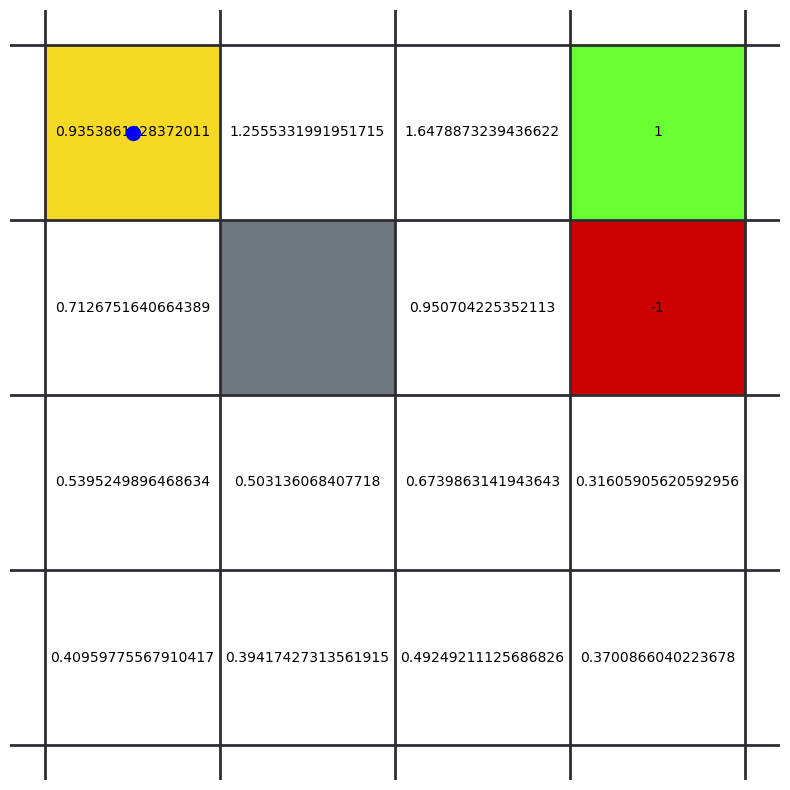

In [24]:
#Visualización de los resultados
for s in a.values:
    a.mdp.grid[s[0]][s[1]] = a.get_value(s)

a.mdp.plot()

#### Preguntas de reflexión

1. Aumente o disminuya la cantidad de iteraciones y el factor de descuento al crear la clase `ValueIteration`. ¿Existe alguna diferencia entre las ejecuciones? 
2. Si existe diferencia entre las ejecuciones ¿Puede explicar por qué? Si no existe diferencia ¿Puede explicar por qué?